In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
%load_ext autoreload
%autoreload 2

In [3]:
already_merged=False

# fmcw_data_base_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/FMCW'
fmcw_data_base_dir = '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc'
fmcw_output_base_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/FMCW'

# Uncomment below for March 27th, 2017 case
date = '0327'
starttimestring = '201703271900'
endtimestring = '201703272200'

starttimestring2 = '2017-03-27T19:00'
endtimestring2 = '2017-03-27T22:00'

# Uncomment below for April 30th, 2017 case
# date = '0430'
# starttimestring = '201704302000'
# endtimestring = '201704302359

# fmcw_data_dir = os.path.join(fmcw_data_base_dir, date)
fmcw_data_dir = fmcw_data_base_dir
fmcw_output_dir = os.path.join(fmcw_output_base_dir, date)
if not os.path.exists(fmcw_output_dir):
        os.makedirs(fmcw_output_dir)

if not already_merged:
    filepaths = fmcw.get_fmcw_filepaths(fmcw_data_dir, starttimestring, endtimestring, subdirs=False)
    print(filepaths)

    # Read in multifile FMCW dataset
    fmcw_merged_dataset = fmcw.read_fmcw_multifile_xarray(filepaths)
    # Clip to chosen times
    fmcw_merged_dataset = fmcw_merged_dataset.sel(time=slice(starttimestring2, endtimestring2))
    # Dealias
    fmcw_merged_dataset = fmcw.dealias(fmcw_merged_dataset)
    fmcw_merged_dataset.load()
    
else:    
    fmcw_filename = 'fmcw_merged_corrected_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_data_dir, fmcw_filename)
    fmcw_merged_dataset = xr.open_dataset(fmcw_filepath)

print(fmcw_merged_dataset)

['/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170327T210132.nc', '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170327T190412.nc', '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170327T200019.nc', '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc/S20170327T220245.nc']


/Users/dawson29/Projects/pyPIPS/pyPIPS/fmcw.py:169: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  fmcw_dataset = xr.open_mfdataset(filelist, preprocess=preprocess_fmcw_xarray)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:  (height: 1024, time: 1128, vels: 256)
Coordinates:
  * height   (height) float64 1.0 5.0 10.0 15.0 ... 5.105e+03 5.11e+03 5.115e+03
  * time     (time) datetime64[ns] 2017-03-27T19:04:24 ... 2017-03-27T23:03:51
  * vels     (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
Data variables:
    Zef      (time, height, vels) float64 -99.0 -99.0 -99.0 ... -15.5 -15.1
    sf       (time, height, vels) int16 -275 -275 -266 -256 ... -218 -224 -220
    sn       (time, height) int16 -252 -269 -286 -290 ... -389 -389 -389 -389
    sff      (time, height, vels) int16 -275 -275 -266 -256 ... -218 -224 -220
    snr      (time, height) float64 12.9 10.2 -3.2 -16.3 ... 20.0 20.2 20.2 20.1
    Ze       (time, height) float64 -69.1 -57.8 -65.3 -74.9 ... 12.4 12.3 12.2
    vel      (time, height) float32 -3.1479226e-07 4.1833816 ... 0.32186732
    wid      (time, height) float32 4.8970013 4.6650367 ... 4.2636805 4.2223973
    vel_da   (time, height) float64 nan nan 

In [6]:
# Read in PIPS data
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'
PIPS_filename = 'parsivel_combined_FMCW_2017_{}17_PIPS2A_60s.nc'.format(date)
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.open_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                              (diameter_bin: 32, fallspeed_bin: 32, fields_KHTX: 9, parameter: 3, time: 1441)
Coordinates:
  * time                                 (time) datetime64[ns] 2017-03-27 ... 2017-03-28
    fallspeed                            (fallspeed_bin) float64 ...
    diameter                             (diameter_bin) float64 ...
    min_diameter                         (diameter_bin) float64 ...
    max_diameter                         (diameter_bin) float64 ...
    min_fallspeeds                       (fallspeed_bin) float64 ...
    max_fallspeeds                       (fallspeed_bin) float64 ...
  * parameter                            (parameter) object 'N0' 'lamda' 'alpha'
  * fallspeed_bin                        (fallspeed_bin) float64 0.05 ... 20.8
  * diameter_bin                         (diameter_bin) float64 0.0625 ... 24.5
    flagged_times                        (time) int64 ...
  * fields_KHTX                          (fields_KH

In [7]:
PIPS_ds.load()
PIPS_ds_1900_2200 = PIPS_ds.sel(time=slice("2017-03-27T19:00", "2017-03-27T22:00"))
PIPS_new_file = 'parsivel_combined_FMCW_2017_{}17_PIPS2A_60s_1900-2200.nc'.format(date)
PIPS_new_filepath = os.path.join(PIPS_data_dir, PIPS_new_file)
PIPS_ds.to_netcdf(PIPS_new_filepath)

In [8]:
print(PIPS_ds['KHTX_beam_height_at_PIPS'])

<xarray.DataArray 'KHTX_beam_height_at_PIPS' (time: 1441)>
array([         nan,          nan,          nan, ..., 648.03745226,
       648.03745226,          nan])
Coordinates:
  * time           (time) datetime64[ns] 2017-03-27 ... 2017-03-28
    flagged_times  (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    radar_name:       KHTX
    PIPS_name:        PIPS2A
    PIPS_x:           7199.8044309309935
    PIPS_y:           -27065.8139684841
    elevation_angle:  0.5


<xarray.DataArray 'Ze' (time: 1128, height: 1024)>
array([[-69.1, -57.8, -65.3, ..., -17.8, -18.1, -19.3],
       [-68.9, -57.1, -63.6, ..., -15. , -13.9, -13.8],
       [-68.1, -56.7, -62.7, ..., -11.5, -11.3, -11.5],
       ...,
       [-66.7, -53. , -47.2, ...,  13.2,  13.3,  13.2],
       [-75.3, -56.8, -55. , ...,  13.2,  13.3,  13.4],
       [-74.7, -57.1, -55.5, ...,  12.4,  12.3,  12.2]])
Coordinates:
  * height   (height) float64 1.0 5.0 10.0 15.0 ... 5.105e+03 5.11e+03 5.115e+03
  * time     (time) datetime64[ns] 2017-03-27T19:04:24 ... 2017-03-27T23:03:51
<xarray.DataArray 'Ze_corr' (time: 1128, height: 1024)>
array([[-47.64616435, -36.34616435, -43.84616435, ...,   3.65383565,
          3.35383565,   2.15383565],
       [-47.44616435, -35.64616435, -42.14616435, ...,   6.45383565,
          7.55383565,   7.65383565],
       [-46.64616435, -35.24616435, -41.24616435, ...,   9.95383565,
         10.15383565,   9.95383565],
       ...,
       [-45.24616435, -31.54616435, -25.7

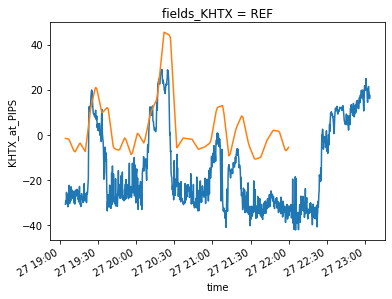

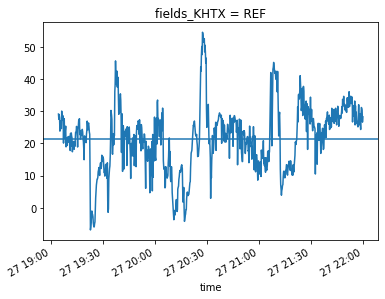

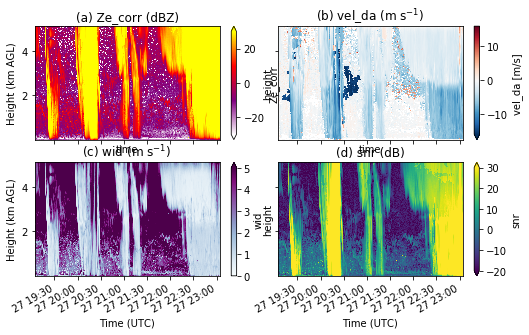

In [10]:
if not already_merged:
    fmcw_merged_dataset = fmcw.correct_fmcw_with_nexrad(fmcw_merged_dataset, PIPS_ds_1900_2200, radar_name='KHTX', 
                                                        dBZ_field='REF', plot=True)
    print(fmcw_merged_dataset['Ze'])
    print(fmcw_merged_dataset['Ze_corr'])
    fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset, dBZ_var='Ze_corr')
    print(fmcw_merged_dataset)
    fmcw_filename = 'fmcw_merged_corrected_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_output_dir, fmcw_filename)
    fmcw_merged_dataset.to_netcdf(fmcw_filepath)

In [11]:
%matplotlib inline
# plt.rcParams["figure.figsize"] = (20,10)
# fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset)
fmcw_merged_resampled_ds = fmcw_merged_dataset.resample(time='10S').interpolate()
print(fmcw_merged_resampled_ds)
fmcw_merged_ds_rolling = fmcw_merged_resampled_ds.rolling(time=6)
fmcw_merged_resampled_ds = fmcw_merged_ds_rolling.mean()
print(fmcw_merged_resampled_ds)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 1438, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
  * time      (time) datetime64[ns] 2017-03-27T19:04:20 ... 2017-03-27T23:03:50
Data variables:
    Zef       (time, height, vels) float64 nan nan nan ... -14.93 -15.46 -15.19
    sf        (time, height, vels) float64 nan nan nan ... -218.3 -223.6 -220.8
    sn        (time, height) float64 nan nan nan nan ... -389.0 -389.0 -389.0
    sff       (time, height, vels) float64 nan nan nan ... -218.3 -223.6 -220.8
    snr       (time, height) float64 nan nan nan nan ... 20.1 20.27 20.28 20.19
    Ze        (time, height) float64 nan nan nan nan ... 12.2 12.47 12.38 12.3
    vel       (time, height) float64 nan nan nan nan ... 0.9511 0.6558 0.2916
    wid       (time, height) float64 nan nan nan nan ... 4.204 4.203 4.219 4.181
    vel_da    (time, height) float64 

In [13]:
fmcw_merged_resampled_at_PIPS_ds = fmcw_merged_resampled_ds.interp_like(PIPS_ds_1900_2200)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 181, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
  * time      (time) datetime64[ns] 2017-03-27T19:00:00 ... 2017-03-27T22:00:00
Data variables:
    Zef       (time, height, vels) float64 nan nan nan nan ... -99.0 -99.0 -99.0
    sf        (time, height, vels) float64 nan nan nan ... -348.9 -345.7 -341.7
    sn        (time, height) float64 nan nan nan nan ... -331.5 -331.5 -332.2
    sff       (time, height, vels) float64 nan nan nan ... -348.9 -345.7 -341.7
    snr       (time, height) float64 nan nan nan nan ... 9.89 10.03 10.03 9.859
    Ze        (time, height) float64 nan nan nan nan ... 2.001 2.147 2.176 1.98
    vel       (time, height) float64 nan nan nan ... -0.1355 -0.06593 -0.02428
    wid       (time, height) float64 nan nan nan nan ... 2.015 2.018 2.019 2.018
    vel_da    (time, height) float6

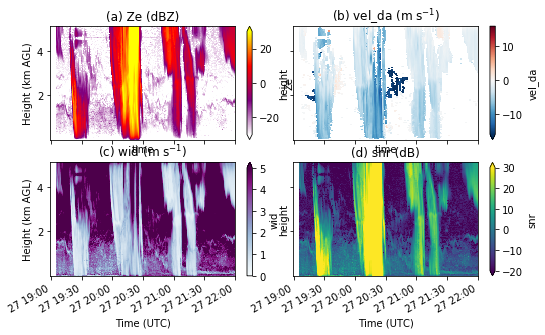

In [14]:
fmcw_merged_resampled_at_PIPS_ds.attrs = fmcw_merged_dataset.attrs
print(fmcw_merged_resampled_at_PIPS_ds)
fmcw.plot_fmcw_4panel_xarray(fmcw_merged_resampled_at_PIPS_ds)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


(181, 32)
<xarray.DataArray 'height' ()>
array(500.)
Coordinates:
    height   float64 500.0
<xarray.DataArray 'Ze_corr' (time: 1128)>
array([-11.14616435,  -8.54616435, -11.54616435, ...,  37.35383565,
        36.15383565,  37.45383565])
Coordinates:
    height   float64 500.0
  * time     (time) datetime64[ns] 2017-03-27T19:04:24 ... 2017-03-27T23:03:51
Attributes:
    bias:     21.45383565119892
start_datetime 2017-03-27 20:00:00
end_datetime 2017-03-27 20:45:00


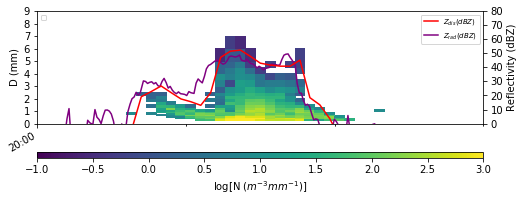

In [21]:
import pyPIPS.parsivel_params as pp
import pyPIPS.polarimetric as dp
min_diameter = pp.parsivel_parameters['min_diameter_bins_mm']
max_diameter = pp.parsivel_parameters['max_diameter_bins_mm']
bin_width = max_diameter - min_diameter
avg_diameter = pp.parsivel_parameters['avg_diameter_bins_mm']
min_fall_bins = pp.parsivel_parameters['min_fallspeed_bins_mps']
max_fall_bins = pp.parsivel_parameters['max_fallspeed_bins_mps']
avg_fall_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']

vd_matrix_da = PIPS_ds_1900_2200['VD_matrix_qc']
ND = PIPS_ds_1900_2200['ND_qc']
logND = np.log10(ND)

# conv_df = pips.calc_thermo(conv_df)
# # empirical_fallspeed = pips.calc_empirical_fallspeed(avg_diameter)
# fallspeed_spectrum = pips.calc_fallspeed_spectrum(avg_diameter, avg_fall_bins, correct_rho=True,
#                                                   rho=conv_df['rho'])
# vd_matrix_da = vd_matrix_da.where(vd_matrix_da > 0.0)
# ND = pips.calc_ND(vd_matrix_da, fallspeed_spectrum, 10.)
# ND = ND.T
# logND = np.log10(ND)
# logND = 

PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)

PSD_edgetimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_edges'])
PSD_centertimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_centers'])

# ND = PIPS_dict['ND'].T
# logND = ma.log10(ND)
# DSD_index = PIPS_dict['DSD_index']
# DSD_interval = PIPS_dict['DSD_interval']
# DSD_interval_td = timedelta(seconds=DSD_interval)
# DSD_halfinterval_td = timedelta(seconds=DSD_interval / 2.)

# Determine start and end times/indices for analysis
# PSDtimestamps = PIPS_dict['PSDtimestamps']
# PSDtimestampsnums = md.date2num(PSDtimestamps)

#     plotstarttime = starttime
#     plotstoptime = stoptime

# pstartindex, pstopindex = getTimeWindow(starttimestring, endtimestring, PSDtimestampsnums)

# pstarttime = PSDtimestampsnums[pstartindex]
# pstoptime = PSDtimestampsnums[pstopindex]

# plotstarttime = pstarttime
# plotstoptime = pstoptime

# PSDtimestamps_edge = [x - DSD_interval_td for x in PSDtimestamps]
# # Add an extra 10 sec for the last time bin boundary
# PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
# PSDtimestamps_avg = [x - DSD_halfinterval_td for x in PSDtimestamps]
# PSDstarttimes = md.date2num(PSDtimestamps_edge[pstartindex:pstopindex + 1])
# PSDmidtimes = md.date2num(PSDtimestamps_avg[pstartindex:pstopindex + 1])

scattfile = '/Users/dawson29/Projects/pyPIPS/tmatrix/FMCW/SCTT_RAIN_fw100.dat'
# Observed DSD: TODO, need to make ND, ND_expDSD, and ND_gamDSD have consistent units!
dualpol_dis = dp.calpolrain(15.0, scattfile, ND, bin_width)
#print(dualpol_dis)
dis_ref = dualpol_dis.get('REF', np.empty((0)))
logND_plot = logND.T
disvars = {'min_diameter': min_diameter, 'PSDstarttimes': PSD_edgetimes,
           'PSDmidtimes': PSD_centertimes, 'logND': logND_plot}
disvars['REF'] = dis_ref

# Quick and dirty rayleigh scattering approximation

M6 = []
print(ND.shape)
for t in range(ND.shape[0]):
    temp_M6 = ((avg_diameter[:] / 1000.)**6.) * (1000. * ND[t, :]) * bin_width[:] / 1000.
    temp_M6 = np.nansum(temp_M6)
    M6.append(temp_M6)

M6 = np.array(M6, dtype=np.float64)
refl_disd = 10.0 * np.log10(1e18 * M6)
#disvars['dBZ'] = refl_disd

# fig, ax = plt.subplots(figsize=(8, 3))

# ax.plot(PSD_centertimes, disvars['dBZ'])

radz = 500. # (m) Height of FMCW gate to plot
radzindex = int(radz/5.)

plotx_rad = fmcw_merged_dataset['time'].values
#dBZ_D_plt = fmcw_merged_dataset['Ze'].values[:, radzindex] + 10.**(2.*7.3/10.)
dBZ_D_plt = fmcw_merged_dataset['Ze_corr'].values[:, radzindex]


print(fmcw_merged_dataset['height'][radzindex])
print(fmcw_merged_dataset['Ze_corr'][:, radzindex])

# fmcw_merged_dataset['Ze'][:, radzindex].plot()

# print(dBZ_D_plt)

radvars = {'radmidtimes': plotx_rad, 'REF': dBZ_D_plt}

# Prepare axis parameters
# timelimits = [md.date2num(datetime.strptime(starttimestring, tm.timefmt3)),
#               md.date2num(datetime.strptime(endtimestring, tm.timefmt3))]
# timelimits = [md.date2num(datetime.strptime('20170430203000', tm.timefmt3)),
#               md.date2num(datetime.strptime('20170430210000', tm.timefmt3))]
# Set up axis parameters
start_time = '20170327200000'
end_time = '20170327204500'
try:
    start_datetime = datetime.strptime(start_time, tm.timefmt3)
    print('start_datetime', start_datetime)
except (ValueError, TypeError):
    start_datetime = PSD_edgetimes[0]
try:
    end_datetime = datetime.strptime(end_time, tm.timefmt3)
    print('end_datetime', end_datetime)
except (ValueError, TypeError):
    end_datetime = PSD_edgetimes[-1]
timelimits = [start_datetime, end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0

locator = md.HourLocator(interval=1)
minorlocator = md.MinuteLocator(byminute=[0,15,30,45])
# minorlocator = md.HourLocator(interval=1)
#dateformat = '%d/%H'
dateformat = '%H:%M'
formatter = md.DateFormatter(dateformat)
axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

            # Ok, now we should have everything ready to go to plot the meteograms.
            # Let'er rip!
meteogram_image_dir = './'
dis_plot_name = 'PIPS1A_observed'
pm.plotDSDmeteograms(dis_plot_name, meteogram_image_dir,
                     axparams, disvars, radvars.copy(), close_fig=False)

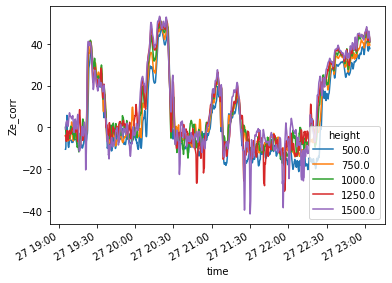

In [22]:
dBZ_D_plt = fmcw_merged_resampled_ds['Ze_corr']
dBZ_D_plt.sel(height=[500., 750., 1000., 1250., 1500.]).plot.line(x='time')

<xarray.Dataset>
Dimensions:   (height: 1024, time: 46, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
  * time      (time) datetime64[ns] 2017-03-27T20:00:00 ... 2017-03-27T20:45:00
Data variables:
    Zef       (time, height, vels) float64 -99.82 -106.3 ... -86.08 -75.08
    sf        (time, height, vels) float64 -256.9 -250.2 ... -343.1 -349.5
    sn        (time, height) float64 -253.6 -270.8 -274.1 ... -342.0 -342.3
    sff       (time, height, vels) float64 -256.9 -250.2 ... -343.1 -349.5
    snr       (time, height) float64 14.18 11.74 -2.342 ... -17.65 -28.76 -18.05
    Ze        (time, height) float64 -67.8 -56.26 -64.36 ... -35.78 -25.93
    vel       (time, height) float64 -1.921e-07 5.38 -2.546 ... -2.563 -1.273
    wid       (time, height) float64 5.284 4.872 4.458 6.457 ... 6.593 6.949 6.8
    vel_da    (time, height) float64 nan nan nan nan nan ..

Text(0, 0.5, 'Height (km AGL)')

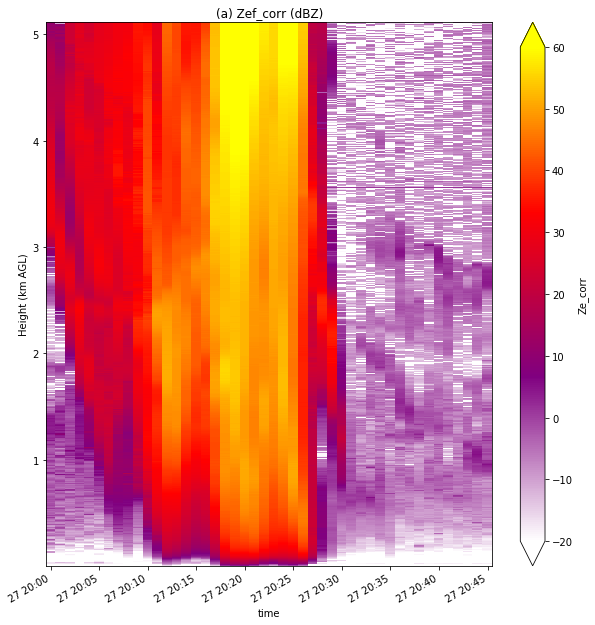

In [27]:
fmcw_merged_resampled_at_PIPS_ds_2000_2045 = fmcw_merged_resampled_at_PIPS_ds.sel(
    time=slice('2017-03-27T20:00', '2017-03-27T20:45'))

print(fmcw_merged_resampled_at_PIPS_ds_2000_2045)

fig, ax = plt.subplots(figsize=(10, 10))

# Reflectivity (Ze)
#     m1 = ax[0, 0].pcolormesh(UTCtime, height/1000., Ze.T,cmap=plasma_white, \
#                              vmin=-30., vmax=30.)

m1 = fmcw_merged_resampled_at_PIPS_ds_2000_2045['Ze_corr'].plot(x='time', y='height', ax=ax, 
                                                                cmap=fmcw.plasma_white, vmin=-20., vmax=60.)

ax.set_title("(a) " + fmcw_merged_resampled_at_PIPS_ds_2000_2045['Zef_corr'].name + " (dBZ)")
ax.set_ylim(fmcw_merged_resampled_at_PIPS_ds_2000_2045['height'].min(), 
            fmcw_merged_resampled_at_PIPS_ds_2000_2045['height'].max())
# ax[0, 0].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
# ax[0, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(mtokm))
#plt.xticks(rotation=30)
#ax[0, 0].set_xlabel("Time (UTC)")
ax.set_ylabel("Height (km AGL)")
# plt.colorbar(m1,ax=ax[0, 0])

#     # Dealiased Doppler (vertical) velocity (vel_da)

#     m2 = dataset['vel_da'].plot(x='time', y='height', ax=ax[0, 1], cmap=cm.RdBu_r,
#                                 vmin=-2.*np.ceil(dataset.Vmax), vmax=2.*np.ceil(dataset.Vmax))

# #     m2 = ax[0, 1].pcolormesh(UTCtime,height/1000., vel.T, cmap=cm.RdBu_r, \
# #                              vmin=-1.*np.ceil(Vmax), vmax=np.ceil(Vmax))

#     ax[0, 1].set_title("(b) " + dataset['vel_da'].name + r" (m s$^{-1}$)")
#     ax[0, 1].set_ylim(dataset['height'].min(), dataset['height'].max())
#     # ax[0, 1].xaxis.set_major_locator(md.MinuteLocator(byminute=range(0, 60, 10)))
#     # ax[0, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
#     ax[0, 1].yaxis.set_major_formatter(ticker.FuncFormatter(mtokm))
#     #plt.xticks(rotation=30)
#     #ax[0, 1].set_xlabel("Time (UTC)")
#     #ax[0, 1].set_ylabel("Height (km AGL)")
#     # plt.colorbar(m2,ax=ax[0, 1])

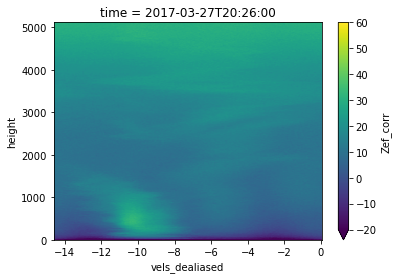

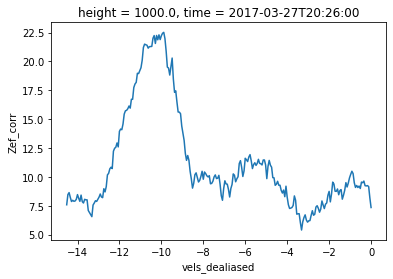

In [41]:
vbins = fmcw_merged_resampled_at_PIPS_ds['vels']
vbins_dealias = vbins - vbins[-1]
fmcw_merged_resampled_at_PIPS_ds.coords['vels_dealiased'] = ('vels', vbins_dealias)
#print(fmcw_merged_resampled_at_PIPS_ds)
Zef_corr = fmcw_merged_resampled_at_PIPS_ds['Zef_corr']
#print(Zef_corr)
#print(Zef_corr.loc['2017-04-30T22:30':'2017-04-30T22:31'])
Zef_corr_onetime = Zef_corr.sel(time='2017-03-27T20:26')
# print(Zef_corr_2230)
Zef_corr_onetime = Zef_corr_onetime.roll(vels=128, roll_coords=False)
#delta_v = Zef_corr_2230.vels[1] - Zef_corr_2230.vels[0]
#print(2. / delta_v)
#shift = int(2. / delta_v)
#Zef_corr_2230_shifted = Zef_corr_2230.roll(vels=shift, roll_coords=False)
Zef_corr_onetime_z2000 = Zef_corr_onetime.sel(height=1000.)
Zef_corr_onetime.plot(x='vels_dealiased', y='height', vmin=-20, vmax=60)
#fig2, ax2 = plt.subplots()
#Zef_corr_2230_shifted.plot(ax=ax2, vmin=-30, vmax=30)
fig, ax = plt.subplots()
Zef_corr_onetime_z2000.plot(ax=ax, x='vels_dealiased')

#Zef_corr_2230.plot(vmin=0., vmax=40.)

In [ ]:
# Let's make a ridge plot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

print(df)


Zef_corr_2230_thinned = Zef_corr_2230.thin({'height': 100})

Zef_corr_2230_df = Zef_corr_2230_thinned.to_dataframe().reset_index()
print(Zef_corr_2230_df)
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(Zef_corr_2230_df, row="height", hue='height', aspect=2, height=1., palette=pal)

# Draw the densities in a few steps
#g.map(sns.kdeplot, "vels_dealiased", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(sns.kdeplot, "vels_dealiased", clip_on=False, color="w", lw=2, bw=.2)
g.map(sns.lineplot, "vels_dealiased", "Zef_corr", clip_on=False, alpha=1, lw=1.5)
#g.map(sns.lineplot, "vels_dealiased", "Zef_corr", clip_on=False, color="w", lw=2, bw=.2)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "vels_dealiased")

# Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
#g.set(yticks=[])
#g.despine(bottom=True, left=True)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m
print(df)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)